# Personalised News Aggregator Machine Learning Model
## Title of the project : Personalized News Aggregator and Sentiment Analyzer
### Project is for the final year of my university.
This model is essentially the backbone of the website which will aggregate news articles from various sources based on user preferences and performs sentiment analysis to provide users with personalized news content. 
#### Importing the necessary libraries:

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from wordcloud import WordCloud,STOPWORDS
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from textblob import TextBlob
from textblob import Word

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


Reading the CSV file.

In [2]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [3]:
df.shape

(50000, 2)

In [4]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
df['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

As seen above the dataset is balanced and there is no need for randomly copying the number of items in any class.
#### Preprocessing the dataset:
- Text Cleaning: Removing HTML tags, special characters, and unnecessary whitespace.
- Tokenization: Splitting the text into individual words(tokens).
- Lowercasing: Converting all the words to lowercase for uniformity.
- Stop Words Removal: Removing the common words that don't contribute much to the sentiment (e.g., 'is', 'and', 'the').
- Stemming/Lemmatization: Reducing the words to their root form.

In [6]:
tokenizer = ToktokTokenizer() # Tokenization of the text.
stopword_list = nltk.corpus.stopwords.words('english') # Making the list of English stop words.

In [7]:
def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    
    return soup.get_text()

def remove_sq_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
                  
def apply_func(text):
    text = remove_html(text)
    text = remove_sq_brackets(text)
    
    return text

df['review'] = df['review'].apply(apply_func) # Applying both the functions remove_html and remove_sq_brackets by the help of the apply_func function.

In [8]:
def remove_sp_char(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', text)
    
    return text

df['review'] = df['review'].apply(remove_sp_char) # Removing the special characters from the review column of the dataframe.

In [9]:
def stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    
    return text

df['review'] = df['review'].apply(stemmer) # Stemming the review column of the dataframe.

In [10]:
stop = set(stopwords.words('english'))
print(stop)

def remove_stopwords(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

df['review'] = df['review'].apply(remove_stopwords) # Removing stop words from the review column of the data frame.

{'through', 'into', 'such', 'you', 'between', 'when', "shouldn't", 'wasn', 'just', 'ain', 'some', 'and', 'for', 'but', "it's", 'on', 'at', 'herself', 'is', 'those', 'd', "wasn't", 'so', 'shan', 'down', 'myself', "needn't", 'don', 'being', 'theirs', 'y', 'him', 'few', 'shouldn', "hasn't", 'i', 'does', 'we', 'which', 'do', 'before', 'if', 'had', 'by', "isn't", 'as', 'isn', "weren't", 'until', 'weren', "you'd", 'very', 'did', 'of', 'should', 'from', 'themselves', "wouldn't", "mightn't", 'hasn', 'a', 'been', "haven't", 'her', 'are', 'an', 'off', 'or', 'nor', 'further', 'because', 'they', "you've", 'to', 'no', 'yourself', 'all', "you'll", 'can', 'the', 'this', 'about', 'he', 'while', 'haven', 'whom', 'doing', 'once', 'm', 'under', 'each', 'most', 'didn', "shan't", "don't", 'over', 'himself', "she's", 'his', 'wouldn', 'what', 'more', 'o', 'too', 'their', "mustn't", 'here', 'now', "couldn't", 'itself', "you're", 'my', 'mustn', 'then', 'own', "should've", 'where', 'any', 'during', 'how', 'were

### Train Test split of the normalized reviews.

In [11]:
norm_train_reviews = df.review[:40000] # Distributing the reviews into training set.
norm_train_reviews[0]

'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

In [12]:
norm_test_reviews = df.review[40000:] # Distributing the reviews into testing set.
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

#### Bags of Words Model

The Bag of Words model represents a text (such as a sentence or document) as a collection of individual words, disregarding grammar, word order, and the context of the words. Each word is treated as an independent entity, and the model captures only the frequency of words in the text.

In the BoW model:
- Words are referred to as "tokens" or "features."
- The "bag" refers to the fact that the words are treated as if they are just placed in a bag, without concern for the order in which they appear.

In [13]:
cv = CountVectorizer(min_df = 0, max_df = 1, binary  = False, ngram_range = (1, 3)) # Count vectorizer for bag of words.
cv_train_reviews= cv.fit_transform(norm_train_reviews) # Transforming the train reviews.
cv_test_reviews = cv.transform(norm_test_reviews) #Transforming the test reviews

print('Bag of Words Count Vectorizer:')
print('Train:', cv_train_reviews.shape)
print('Test:', cv_test_reviews.shape)

Bag of Words Count Vectorizer:
Train: (40000, 6209089)
Test: (10000, 6209089)


##### Term Frequency-Inverse Document Frequency(TF-IDF) Model

TF-IDF combines two metrics:
- Term Frequency (TF): This measures how frequently a word appears in a document.
- Inverse Document Frequency (IDF): This measures how unique or rare a word is across all documents in the corpus.

In [14]:
tv = TfidfVectorizer(min_df = 0, max_df = 1, use_idf = True, ngram_range = (1, 3)) # TF-IDF vectorizer.
tv_train_reviews = tv.fit_transform(norm_train_reviews) # Transforming the train reviews.
tv_test_reviews = tv.transform(norm_test_reviews) # Transforming the test reviews.

print('TF-IDF Train:', tv_train_reviews.shape)
print('TF-IDF Test:', tv_test_reviews.shape)

TF-IDF Train: (40000, 6209089)
TF-IDF Test: (10000, 6209089)


#### Labelling the sentiment column.

Basically converting the 'positive' and 'negative' labels to 1 and 0 respectively.

In [15]:
lb = LabelBinarizer()
sentiment_data = lb.fit_transform(df['sentiment']) # Transforming the sentiment data.

print(sentiment_data.shape)

(50000, 1)


### Splitting the sentiment column into training and testing data.

In [16]:
train_sentiments = sentiment_data[:40000]
test_sentiments = sentiment_data[40000:]

print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


### Loading the Models.

#### Using Logistic regression for both the Bag of Words and the TF-IDF features.

In [17]:
lr = LogisticRegression(penalty = 'l2', max_iter = 500, C = 1, random_state = 42) # Initialising the model.

lr_bow = lr.fit(cv_train_reviews, train_sentiments) # Fitting the model for the Bag of words features.
print(lr_bow)

lr_tfidf = lr.fit(tv_train_reviews, train_sentiments) # Fitting the model for the TF-IDF features.
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


##### Logistic Regression Model performance on the test data.

In [18]:
lr_bow_predict = lr.predict(cv_test_reviews) # Predicting for the Bag of Words features.
print(lr_bow_predict)

lr_tfidf_predict = lr.predict(tv_test_reviews) # Predicting for the TF-IDF features.
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


Accuracy of the logistic regression model.

In [19]:
lr_bow_score = accuracy_score(test_sentiments, lr_bow_predict) # Score for the Bag of Words features.
print("lr_bow_score :", lr_bow_score)

lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict) # Score for the TF-IDF features.
print("lr_tfidf_score :", lr_tfidf_score)

lr_bow_score : 0.7512
lr_tfidf_score : 0.75


Printing the report.

In [20]:
lr_bow_report = classification_report(test_sentiments, lr_bow_predict, target_names = ['Positive', 'Negative']) # For bag of words features.
print('The report for the bag of words features:')
print(lr_bow_report)

lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict, target_names = ['Positive', 'Negative']) # For TF-IDF features.
print('The report for the TF-IDF features:')
print(lr_tfidf_report)

The report for the bag of words features:
              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

The report for the TF-IDF features:
              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Confusion Matrix.

In [21]:
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels = [1, 0])
print('Confusion Matrix for the Bag of Words features:')
print(cm_bow)

cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels = [1, 0])
print('Confusion Matrix for the TF-IDF features:')
print(cm_tfidf)

Confusion Matrix for the Bag of Words feature:
[[3768 1239]
 [1249 3744]]
Confusion Matrix for the TF-IDF feature:
[[3663 1344]
 [1156 3837]]


#### Using the Stochastic Gradient Descent or Linear Support Vector Machines for the Bag of Words and the TF-IDF Features.

In [22]:
svm = SGDClassifier(loss = 'hinge', max_iter = 500, random_state = 42) # Initialising the model.

svm_bow = svm.fit(cv_train_reviews, train_sentiments) # Fitting the svm for the Bag of Words features.
print(svm_bow)

svm_tfidf = svm.fit(tv_train_reviews, train_sentiments) # Fitting the svm for the TF-IDF features.
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


Model performance on both the features.

In [23]:
svm_bow_predict = svm.predict(cv_test_reviews) # Predicting for the Bag of Words features.
print(svm_bow_predict)

svm_tfidf_predict = svm.predict(tv_test_reviews) # Predicting for the TF-IDF features.
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


Accuracy of SVM.

In [25]:
svm_bow_score = accuracy_score(test_sentiments, svm_bow_predict) # Bag of Words.
print("svm_bow_score :", svm_bow_score)

svm_tfidf_score=accuracy_score(test_sentiments,svm_tfidf_predict) # TF-IDF.
print("svm_tfidf_score :", svm_tfidf_score)

svm_bow_score : 0.5829
svm_tfidf_score : 0.5112


Printing the report.

In [26]:
svm_bow_report = classification_report(test_sentiments, svm_bow_predict, target_names = ['Positive', 'Negative'])
print('The report for the bag of words features:')
print(svm_bow_report)

svm_tfidf_report = classification_report(test_sentiments, svm_tfidf_predict, target_names = ['Positive', 'Negative']) 
print('The report for the TF-IDF features:')
print(svm_tfidf_report)

The report for the bag of words features:
              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000

The report for the TF-IDF features:
              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



Confusion Matrix.

In [27]:
cm_bow = confusion_matrix(test_sentiments, svm_bow_predict, labels = [1, 0])
print('Confusion Matrix for the Bag of Words features:')
print(cm_bow)

cm_tfidf = confusion_matrix(test_sentiments, svm_tfidf_predict, labels = [1, 0])
print('Confusion Matrix for the TF-IDF features:')
print(cm_tfidf)

Confusion Matrix for the Bag of Words features:
[[4948   59]
 [4112  881]]
Confusion Matrix for the TF-IDF features:
[[5007    0]
 [4888  105]]


#### Using the Multinomial Naive Bayes for the Bag of Words and the TF-IDF Features.

In [28]:
mnb = MultinomialNB() # Initialising the model.

mnb_bow = mnb.fit(cv_train_reviews, train_sentiments) # Fitting for the Bag of Words features.
print(mnb_bow)

mnb_tfidf = mnb.fit(tv_train_reviews,train_sentiments) # Fitting for the TF-IDF features
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


Model performance on both the features.

In [29]:
mnb_bow_predict = mnb.predict(cv_test_reviews) # Predicting for the Bag of Words features.
print(mnb_bow_predict)

mnb_tfidf_predict = mnb.predict(tv_test_reviews) # Predicting for the TF-IDF features.
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


Accuracy of MNB.

In [30]:
mnb_bow_score = accuracy_score(test_sentiments, mnb_bow_predict) # Bag of Words.
print("mnb_bow_score :", mnb_bow_score)

mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict) # TF-IDF.
print("mnb_tfidf_score :", mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


Printing the Report.

In [31]:
mnb_bow_report = classification_report(test_sentiments, mnb_bow_predict, target_names = ['Positive', 'Negative']) 
print('The report for the bag of words features:')
print(mnb_bow_report)

mnb_tfidf_report = classification_report(test_sentiments, mnb_tfidf_predict, target_names = ['Positive', 'Negative']) 
print('The report for the TF-IDF features:')
print(mnb_tfidf_report)

The report for the bag of words features:
              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

The report for the TF-IDF features:
              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



Confusion Matrix.

In [32]:
cm_bow = confusion_matrix(test_sentiments, mnb_bow_predict, labels = [1, 0])
print('Confusion Matrix for the Bag of Words features:')
print(cm_bow)

cm_tfidf = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels = [1, 0])
print('Confusion Matrix for the TF-IDF features:')
print(cm_tfidf)

Confusion Matrix for the Bag of Words features:
[[3736 1271]
 [1219 3774]]
Confusion Matrix for the TF-IDF features:
[[3729 1278]
 [1213 3780]]


### Word Clouds.

Positive Word Cloud:



<function matplotlib.pyplot.show(close=None, block=None)>

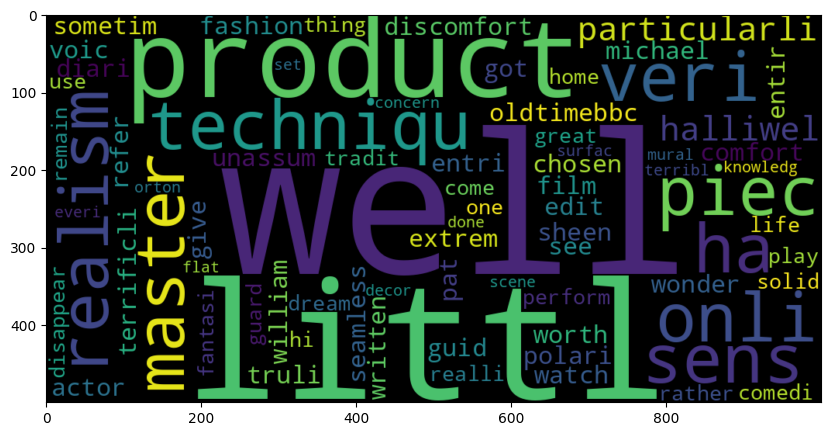

In [33]:
print('Positive Word Cloud:\n')
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

Negative Word Cloud:



<function matplotlib.pyplot.show(close=None, block=None)>

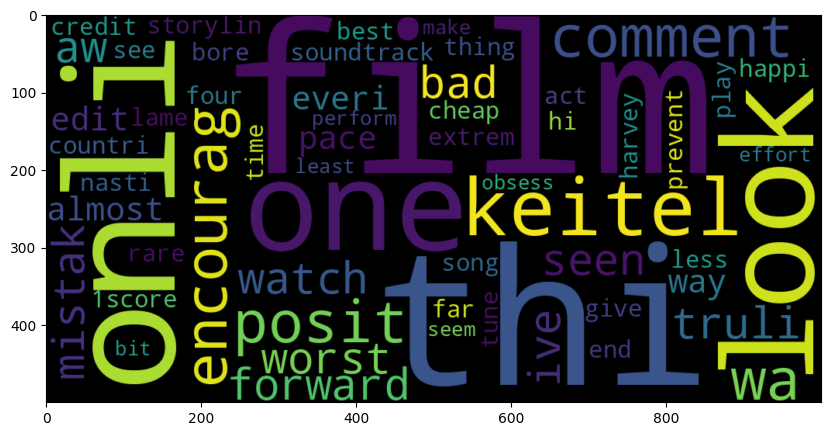

In [34]:
print('Negative Word Cloud:\n')
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show